In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
df_trec = pd.read_parquet("../../../data/metadata_TREC.parquet")
df_ceur = pd.read_parquet("../../../data/metadata_CEUR.parquet")
df_lncs = pd.read_parquet("../../../data/metadata_LNCS.parquet")
df_lncs.loc[df_lncs['ID'] == "lncs_649", 'Section'] = "CLEF at SemEval 2007"

In [3]:
# Add citation data from Semantic Scholar to the dataframes

def add_SemanticCitations(df, path):
    with open(path, 'r', encoding="utf-8") as file:
        SemanticCitations = json.load(file)
    
    citations_semantic = []
    for i in SemanticCitations:
        try:
            citations_semantic.append([i, SemanticCitations[i]["citationCount"]])
        except:
            print(i)
    df_citations = pd.DataFrame(citations_semantic, columns=["ID", "Citations_semantic"])
    merge = pd.merge(df, df_citations, how="left" , left_on = "ID", right_on="ID")
    return merge

In [4]:
df_lncs = add_SemanticCitations(df_lncs, "../../../data/SemanticScholar_LNCS_additional_metadata.json")
df_trec = add_SemanticCitations(df_trec, "../../../data/SemanticScholar_TREC_additional_metadata.json")
df_ceur = add_SemanticCitations(df_ceur, "../../../data/SemanticScholar_CEUR_additional_metadata.json")

In [5]:
# Add citation data from OpenAlex to the dataframes

def add_OpenAlexCitations(df, path):
    with open(path, 'r', encoding="utf-8") as file:
        OpenAlexCitations = json.load(file)
    
    citations_OpenAlex = []
    for i in OpenAlexCitations:
        try:
            citations_OpenAlex.append([i, OpenAlexCitations[i]["cited_by_count"]])
        except:
            print(i)
    df_citations = pd.DataFrame(citations_OpenAlex, columns=["ID", "Citations_OpenAlex"])
    merge = pd.merge(df, df_citations, how="left" , left_on = "ID", right_on="ID")
    return merge

In [6]:
df_lncs = add_OpenAlexCitations(df_lncs, "../../../data/OpenAlex_LNCS.json")
df_trec = add_OpenAlexCitations(df_trec, "../../../data/OpenAlex_TREC.json")
df_ceur = add_OpenAlexCitations(df_ceur, "../../../data/OpenAlex_CEUR.json")

In [7]:
# Cast PubYear column into integer

df_lncs['PubYear'] = pd.to_numeric(df_lncs['PubYear'], errors='coerce').astype(int)
df_ceur['PubYear'] = pd.to_numeric(df_ceur['PubYear'], errors='coerce').astype(int)

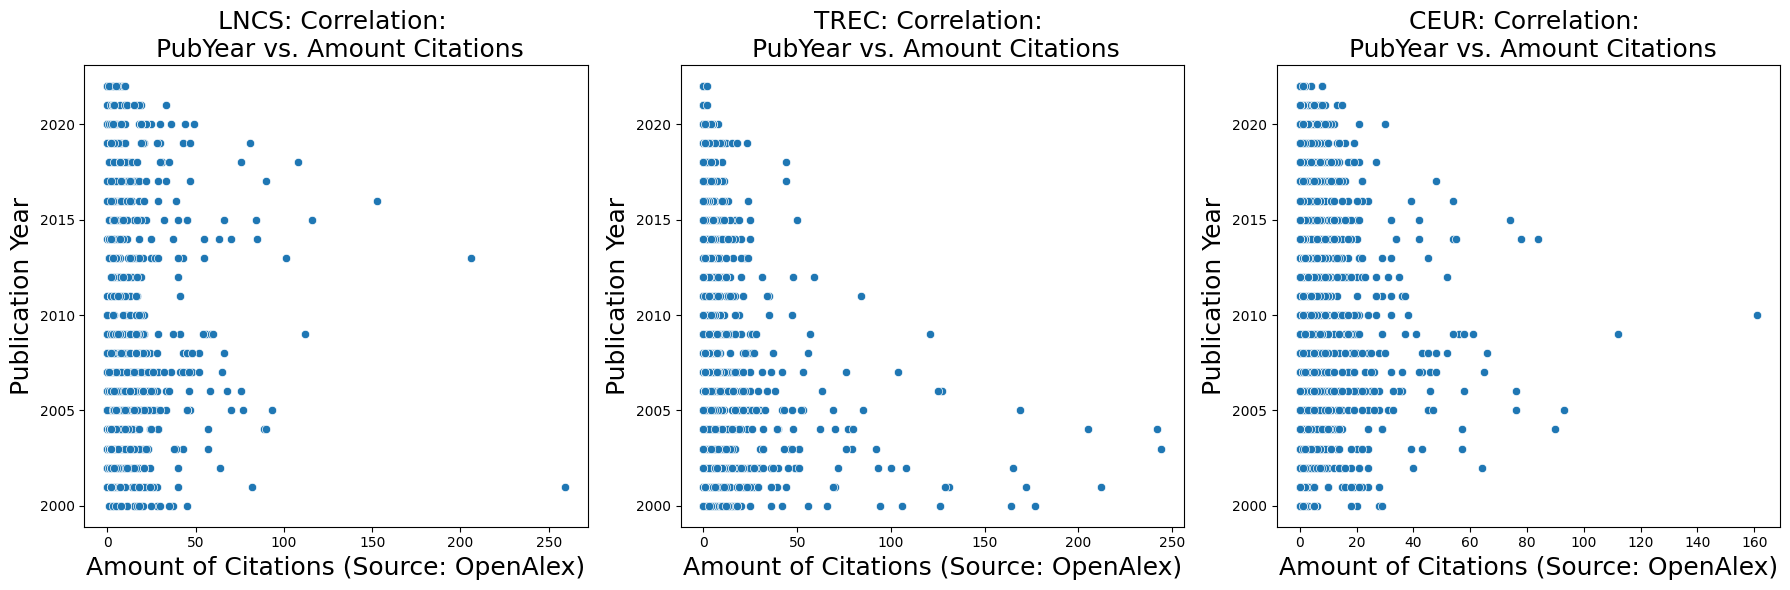

In [13]:
dataframes = [df_lncs, df_trec, df_ceur]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  

proceedings = ["LNCS", "TREC", "CEUR"]

for i, df in enumerate(dataframes):
    sns.scatterplot(y='PubYear', x='Citations_OpenAlex', data=df, ax=axes[i])
    axes[i].set_title(f'{proceedings[i]}: Correlation: \n PubYear vs. Amount Citations', fontsize=18)
    axes[i].set_xlabel('Amount of Citations (Source: OpenAlex)', fontsize=18)  
    axes[i].set_ylabel('Publication Year', fontsize=18)    
    
plt.tight_layout()
plt.savefig('../../../images/correlation_pubyear_citations.png', dpi=300)  # Save the figure as a PNG file with 300 dpi
plt.show()

In [9]:
import scipy.stats as stats
import pandas as pd
import numpy as np

def calculate_pearson_correlation(df, citation_columns):
    results = {}

    for column in citation_columns:
        clean_df = df[np.isfinite(df['PubYear']) & np.isfinite(df[column])]

        # Calculate Pearson correlation and the p-value
        corr, p_value = stats.pearsonr(clean_df['PubYear'], clean_df[column])
        
        results[f'{column}_correlation'] = corr
        results[f'{column}_p_value'] = p_value
    
    return results

citation_columns = ['Citations_OpenAlex', 'Citations_semantic']
results = calculate_pearson_correlation(df_lncs, citation_columns)
print(results)

{'Citations_OpenAlex_correlation': 0.0028012556247499726, 'Citations_OpenAlex_p_value': 0.9219767235163787, 'Citations_semantic_correlation': 0.05254470673054998, 'Citations_semantic_p_value': 0.07034874269315759}


In [10]:
results = calculate_pearson_correlation(df_trec, citation_columns)
print(results)

{'Citations_OpenAlex_correlation': -0.2773626883643291, 'Citations_OpenAlex_p_value': 1.4123550518215413e-31, 'Citations_semantic_correlation': -0.22003236503171056, 'Citations_semantic_p_value': 6.160645767741417e-22}


In [11]:
results = calculate_pearson_correlation(df_ceur, citation_columns)
print(results)

{'Citations_OpenAlex_correlation': -0.21307005415304658, 'Citations_OpenAlex_p_value': 1.066872525223095e-30, 'Citations_semantic_correlation': -0.07023589565795414, 'Citations_semantic_p_value': 8.643792103317881e-05}


In [12]:
import scipy.stats as stats

def perform_stat_tests(group1, group2):
    results = {}

    # Shapiro-Wilk Test to test for normal-distribution 
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)
    results['Shapiro_Wilk_Group1_p'] = shapiro_group1.pvalue
    results['Shapiro_Wilk_Group2_p'] = shapiro_group2.pvalue

    # Levene test for variance homogeneity
    levene_test = stats.levene(group1, group2)
    results['Levene_p'] = levene_test.pvalue

    # Determine whether both groups are normally distributed
    normal_group1 = shapiro_group1.pvalue > 0.05
    normal_group2 = shapiro_group2.pvalue > 0.05

    # If both groups are normally distributed, t-test or Welch's t-test based on Levene
    if normal_group1 and normal_group2:
        if levene_test.pvalue > 0.05:     # Variance homogeneity fulfilled
            t_test = stats.ttest_ind(group1, group2)
            results['Test'] = 't-test'
            results['Test_p'] = t_test.pvalue
        else:     # Variance homogeneity not fulfilled
            welch_test = stats.ttest_ind(group1, group2, equal_var=False)
            results['Test'] = 'Welch t-test'
            results['Test_p'] = welch_test.pvalue
    else:
        # If one or both groups are not normally distributed, Mann-Whitney U test
        mann_whitney = stats.mannwhitneyu(group1, group2)
        results['Test'] = 'Mann-Whitney U'
        results['Test_p'] = mann_whitney.pvalue

    return results


test_results = perform_stat_tests(df_lncs["PubYear"], df_lncs["Citations_OpenAlex"])
print(test_results)

{'Shapiro_Wilk_Group1_p': 4.010706905105498e-25, 'Shapiro_Wilk_Group2_p': 3.476979907619064e-49, 'Levene_p': 1.237892980640733e-16, 'Test': 'Mann-Whitney U', 'Test_p': 0.0}
